In [26]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import math

import requests

import seaborn as sns
import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



In [27]:
df=pd.read_csv('https://raw.githubusercontent.com/DavidGlezGmz/Time-Series/main/Click%20Counts.csv')

In [28]:
df.columns

Index(['Date', 'Click_Count'], dtype='object')

In [29]:
df=df.rename(columns={'Date':'ds','Click Count':'y'})
df

,ds,Click_Count
0,01/01/16 0:00,2093576
1,02/01/16 0:00,2093576
2,03/01/16 0:00,2093576
3,04/01/16 0:00,2093576
4,05/01/16 0:00,2093576
...,...,...
1280,04/07/19 0:00,2174217
1281,05/07/19 0:00,2530250
1282,06/07/19 0:00,2510980
1283,07/07/19 0:00,2032842


In [30]:
Count = df.drop(['ds'], axis=1)

In [31]:
Count

,Click_Count
0,2093576
1,2093576
2,2093576
3,2093576
4,2093576
...,...
1280,2174217
1281,2530250
1282,2510980
1283,2032842


In [32]:
Count.shape

(1285, 1)

In [33]:
Count = Count.values
Count = Count.astype('float32')
print(Count)

[[2093576.]
 [2093576.]
 [2093576.]
 ...
 [2510980.]
 [2032842.]
 [2291760.]]


In [34]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [35]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(Count)
print(dataset)

[[0.15265204]
 [0.15265204]
 [0.15265204]
 ...
 [0.18308686]
 [0.14822365]
 [0.16710253]]


In [36]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

860 425


In [37]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [38]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX[:3])

[[0.18581706]
 [0.21914105]
 [0.2570144 ]]


In [39]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [40]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
858/858 - 6s - loss: 0.0073 - 6s/epoch - 7ms/step
Epoch 2/100
858/858 - 2s - loss: 0.0049 - 2s/epoch - 2ms/step
Epoch 3/100
858/858 - 2s - loss: 0.0039 - 2s/epoch - 2ms/step
Epoch 4/100
858/858 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 5/100
858/858 - 1s - loss: 0.0023 - 1s/epoch - 1ms/step
Epoch 6/100
858/858 - 1s - loss: 0.0017 - 1s/epoch - 1ms/step
Epoch 7/100
858/858 - 1s - loss: 0.0015 - 1s/epoch - 1ms/step
Epoch 8/100
858/858 - 1s - loss: 0.0014 - 1s/epoch - 1ms/step
Epoch 9/100
858/858 - 1s - loss: 0.0013 - 1s/epoch - 1ms/step
Epoch 10/100
858/858 - 1s - loss: 0.0014 - 1s/epoch - 1ms/step
Epoch 11/100
858/858 - 1s - loss: 0.0014 - 1s/epoch - 1ms/step
Epoch 12/100
858/858 - 1s - loss: 0.0013 - 1s/epoch - 1ms/step
Epoch 13/100
858/858 - 1s - loss: 0.0013 - 1s/epoch - 1ms/step
Epoch 14/100
858/858 - 1s - loss: 0.0013 - 1s/epoch - 1ms/step
Epoch 15/100
858/858 - 1s - loss: 0.0013 - 1s/epoch - 1ms/step
Epoch 16/100
858/858 - 1s - loss: 0.0013 - 1s/epoch - 1ms/step
E

In [41]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 486979.18 RMSE
Test Score: 825281.84 RMSE


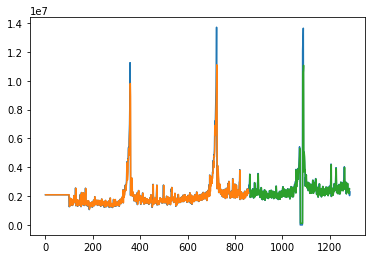

In [42]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()